In [1]:
# Apply fairness-aware data re-sampling (inspired by Ekstrand et al.) on lastfm-nl dataset for RecBole
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Load user profile, label interactions and plays interactions
user_df = pd.read_csv('../Post-processing/datasets/lastfm-nl/lastfm-nl.user', sep='\t')  # user_id:token, gender, age, etc.
inter_df_label = pd.read_csv('../datasets/split_datasets/lastfm-nl/lastfm-nl.train.inter', sep='\t')  # user_id:token, artist_id:token, label
inter_df_plays = pd.read_csv('../Post-processing/datasets/lastfm-nl/lastfm-nl.inter', sep='\t')  # user_id:token, artist_id:token, plays

# 2. Merge plays into train.inter
inter_df = inter_df_label.merge(
    inter_df_plays[['user_id:token', 'artist_id:token', 'plays:float']],
    how='left',
    left_on=['user_id:token', 'artist_id:token'],
    right_on=['user_id:token', 'artist_id:token']
)

# 3. Merge gender info
merged_df = inter_df.merge(
    user_df[['user_id:token', 'gender:token']],
    on='user_id:token',
    how='left'
)

merged_df.rename(columns={'gender:token': 'gender'}, inplace=True)

display(merged_df.head())

,user_id:token,artist_id:token,label:float,plays:float,gender
0,7db20cb306f5c6ee0a7da4b2eabbb12f80a4577d,c7e90641-f441-4801-8e4a-d09e10f452b8,1.0,166,M
1,7db20cb306f5c6ee0a7da4b2eabbb12f80a4577d,41489644-58f8-47e7-a581-e24d5659baeb,1.0,458,M
2,7db20cb306f5c6ee0a7da4b2eabbb12f80a4577d,609e7afd-3552-4102-9501-7611858ea320,1.0,176,M
3,7db20cb306f5c6ee0a7da4b2eabbb12f80a4577d,5251b5a0-3e3b-4d07-a152-585009575310,1.0,193,M
4,7db20cb306f5c6ee0a7da4b2eabbb12f80a4577d,5f6ab597-f57a-40da-be9e-adad48708203,1.0,402,M


In [2]:
# 4. Check gender distribution
female_df = merged_df[merged_df['gender'] == 'F']
male_df = merged_df[merged_df['gender'] == 'M']

female_user_count = female_df['user_id:token'].nunique()
female_positive = female_df[female_df['label:float'] == 1]
female_negative = female_df[female_df['label:float'] == 0]
female_interactions = len(female_df)
print(f"Female users: {female_user_count}, Female interactions: {female_interactions}")
print(f"Female interactions per user: {female_interactions/female_user_count:.4f}")
print(f"Female positive interactions: {len(female_positive)}")
print(f"Female positive ratio: {len(female_positive) / female_interactions:.4f}")

male_user_count = male_df['user_id:token'].nunique()
male_positive = male_df[male_df['label:float'] == 1]
male_negative = male_df[male_df['label:float'] == 0]
male_interactions = len(male_df)
print(f"Male users: {male_user_count}, Male interactions: {male_interactions}")
print(f"Male interactions per user: {male_interactions/male_user_count:.4f}")
print(f"Male positive interactions: {len(male_positive)}")
print(f"Male positive ratio: {len(male_positive) / male_interactions:.4f}")

Female users: 1733, Female interactions: 69381
Female interactions per user: 40.0352
Female positive interactions: 68880
Female positive ratio: 0.9928
Male users: 7059, Male interactions: 287033
Male interactions per user: 40.6620
Male positive interactions: 285760
Male positive ratio: 0.9956


In [3]:
# 5. Balance male/female interactions (oversample famale group)
oversample_amount = female_user_count * (male_interactions/male_user_count)
positive_diff = int(oversample_amount * (len(male_positive) / male_interactions) - len(female_positive))
negtive_diff = int(oversample_amount * (1 - len(male_positive) / male_interactions) - len(female_negative))
print("if oversample famale group:")
print(f"Need to add {oversample_amount - female_interactions:.0f} female interactions.")
print(f"Need to add {positive_diff} positive female interactions.")
print(f"Need to add {negtive_diff} negative female interactions.")
# Target female interaction count to match male ratio
# Get female user ids
female_users = female_df['user_id:token'].unique()
# Get all item ids
all_items = merged_df['artist_id:token'].unique()
female_all_items = female_df['artist_id:token'].unique()
male_al_item = female_df['artist_id:token'].unique()
# Create a set of existing (user, item) interactions for females
existing_pairs = set(zip(female_df['user_id:token'], female_df['artist_id:token']))

import random
random.seed(42)
new_positives = []
while len(new_positives) < positive_diff:
    user = random.choice(female_users, )
    item = random.choice(female_all_items)
    if (user, item) not in existing_pairs:
        new_positives.append({'user_id:token': user,
                              'artist_id:token': item,
                              'label:float': 1, 
                              'gender': 'F'})
        existing_pairs.add((user,item))
      
new_negatives = []
while len(new_negatives) < negtive_diff:
    user = random.choice(female_users)
    item = random.choice(male_al_item)
    if (user, item) not in existing_pairs:
        new_negatives.append({'user_id:token': user,
                              'item_id:token': item,
                              'label:float': 0, 
                              'gender': 'F'})
        existing_pairs.add((user,item))
       
new_samples = new_positives + new_negatives
# Create DataFrame and merge
df_fair = pd.concat([merged_df, pd.DataFrame(new_samples)], ignore_index=True)

if oversample famale group:
Need to add 1086 female interactions.
Need to add 1274 positive female interactions.
Need to add -188 negative female interactions.


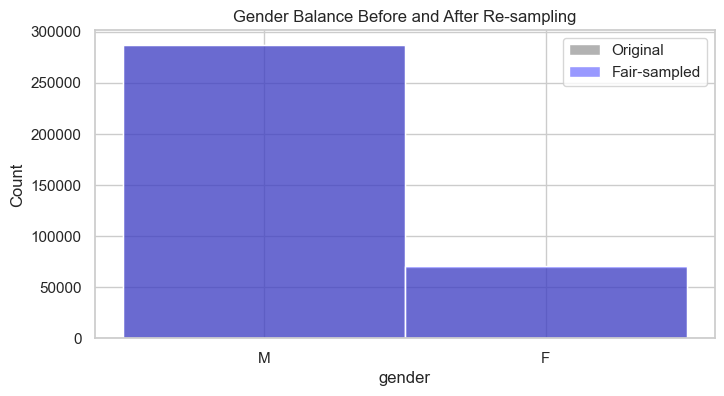

,user_id:token,artist_id:token,label:float,plays:float,gender
0,43a22ad9b45b0cb5cf66a2819d4a4a9acf8efaaf,b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,1.0,512.0,M
1,7aa203ef1b09ad10b7d09cfa2574ff60241eb42a,34e10b51-b5c6-4bc1-b70e-f05f141eda1e,1.0,70.0,M
2,e8ff6610da153e6f13c7e0628d1b0a6b18c774d4,2f94cfb6-a425-48ca-8d8c-87a1f39d2952,1.0,195.0,M
3,a25b555b92cc2186600873c8717035632abf3989,a814e54f-1acb-43a2-ad15-a7f44b03879f,1.0,212.0,M
4,513b820264b6e23efbe48c8c3a80b359cfba72e8,20aa23e3-3532-42ca-acf6-e8c2e9df2688,1.0,248.0,M


In [4]:
#shuffle balanced groups
df_fair = df_fair.sample(frac=1, random_state=42).reset_index(drop=True)

# 7. Optional: plot before and after
plt.figure(figsize=(8,4))
sns.histplot(data=merged_df, x="gender", stat="count", color="gray", label="Original", alpha=0.6)
sns.histplot(data=df_fair, x="gender", stat="count", color="blue", label="Fair-sampled", alpha=0.4)
plt.title("Gender Balance Before and After Re-sampling")
plt.legend()
plt.show()

display(df_fair.head())


In [5]:
# 8. Save oversample interaction set
import os

save_path = 'datasets/lastfm-nl/lastfm-nl.train.inter'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 保存
df_fair[['user_id:token', 'artist_id:token','label:float']].to_csv(
    save_path,
    sep='\t',
    index=False
)
print(f"✅ Fair oversampled dataset saved to {save_path}")

✅ Fair oversampled dataset saved to datasets/lastfm-nl/lastfm-nl.train.inter


In [6]:
import shutil

src_path = '../datasets/split_datasets/lastfm-nl/lastfm-nl.valid.inter'
dst_dir = 'datasets/lastfm-nl'
dst_path = os.path.join(dst_dir, 'lastfm-nl.valid.inter')

os.makedirs(dst_dir, exist_ok=True)

# 复制文件
shutil.copyfile(src_path, dst_path)

print(f"✅ File copied to {dst_path}")

src_path = '../datasets/split_datasets/lastfm-nl/lastfm-nl.test.inter'
dst_path = os.path.join(dst_dir, 'lastfm-nl.test.inter')

# 复制文件
shutil.copyfile(src_path, dst_path)

print(f"✅ File copied to {dst_path}")

✅ File copied to datasets/lastfm-nl/lastfm-nl.valid.inter
✅ File copied to datasets/lastfm-nl/lastfm-nl.test.inter


In [7]:
from recbole.quick_start import run_recbole

run_recbole(config_file_list=['lastfm-nl-oversample.yaml'])

15 Jun 12:01    INFO  ['/Users/huangjiaqing/Desktop/Recommender Systems/RScode/.venv/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/Users/huangjiaqing/Library/Jupyter/runtime/kernel-2db6672d-7b5a-49cd-8188-9fb2dc4c945b.json']
15 Jun 12:01    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 42
state = INFO
reproducibility = True
data_path = datasets/lastfm-nl
checkpoint_dir = checkpoint_saved/lastfm-nl/
show_progress = False
save_dataset = True
dataset_save_path = None
save_dataloaders = True
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 100
train_batch_size = 1024
learner = adam
learning_rate = 0.0005
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'RO', 'group_by': '

15 Jun 12:01    INFO  epoch 0 training [time: 2.67s, train loss: 242.1695]
15 Jun 12:02    INFO  epoch 0 evaluating [time: 11.68s, valid_score: 0.030200]
15 Jun 12:02    INFO  valid result: 
precision@10 : 0.0161    recall@10 : 0.0367    hit@10 : 0.1482    map@10 : 0.0139    ndcg@10 : 0.0302    itemcoverage@10 : 0.0664    averagepopularity@10 : 1164.7462    shannonentropy@10 : 0.0013    giniindex@10 : 0.9976    tailpercentage@10 : 0.0039
15 Jun 12:02    INFO  Saving current: checkpoint_saved/lastfm-nl/BPR-Jun-15-2025_12-01-56.pth
15 Jun 12:02    INFO  epoch 1 training [time: 2.66s, train loss: 205.0541]
15 Jun 12:02    INFO  epoch 1 evaluating [time: 10.91s, valid_score: 0.030300]
15 Jun 12:02    INFO  valid result: 
precision@10 : 0.016    recall@10 : 0.0364    hit@10 : 0.1476    map@10 : 0.014    ndcg@10 : 0.0303    itemcoverage@10 : 0.0113    averagepopularity@10 : 1240.5759    shannonentropy@10 : 0.0063    giniindex@10 : 0.9996    tailpercentage@10 : 0.0011
15 Jun 12:02    INFO  Sa

{'best_valid_score': 0.062,
 'valid_score_bigger': True,
 'best_valid_result': OrderedDict([('precision@10', 0.0349),
              ('recall@10', 0.0795),
              ('hit@10', 0.3021),
              ('map@10', 0.0281),
              ('ndcg@10', 0.062),
              ('itemcoverage@10', 0.1108),
              ('averagepopularity@10', 625.7382),
              ('shannonentropy@10', 0.0014),
              ('giniindex@10', 0.989),
              ('tailpercentage@10', 0.0065)]),
 'test_result': OrderedDict([('precision@10', 0.0335),
              ('recall@10', 0.0762),
              ('hit@10', 0.2933),
              ('map@10', 0.0266),
              ('ndcg@10', 0.0593),
              ('itemcoverage@10', 0.1108),
              ('averagepopularity@10', 625.7382),
              ('shannonentropy@10', 0.0014),
              ('giniindex@10', 0.989),
              ('tailpercentage@10', 0.0065)])}

In [8]:
from recbole.quick_start import load_data_and_model
from recbole.utils.case_study import full_sort_topk
from tqdm import tqdm
import pandas as pd
import numpy as np

# 1. 加载模型和数据
config, model, dataset, train_data, valid_data, test_data = load_data_and_model(
    model_file='checkpoint_saved/lastfm-nl/BPR-Jun-15-2025_12-01-56.pth'
)

# Step 1: Get all internal user IDs
all_uids = list(range(dataset.user_num))

# Step 2: Filter out users who have no interactions in the test set
valid_uids = [uid for uid in tqdm(all_uids) if test_data.uid2history_item[uid] is not None]

# Step 3: Convert to Series

uid_series = np.array(valid_uids)

# Step 4: Run full_sort_topk
topk_scores, topk_index = full_sort_topk(uid_series, model, test_data, k=10, device=config['device'])

# Step 5: Convert internal item IDs to external tokens
external_item_lists = [dataset.id2token(dataset.iid_field, row.cpu().tolist()) for row in topk_index]
external_user_list = [dataset.id2token(dataset.uid_field, [uid])[0] for uid in uid_series]
score_lists = [row.cpu().tolist() for row in topk_scores]

# load gender information
user_df = pd.read_csv('../Post-processing/datasets/lastfm-nl/lastfm-nl.user', sep='\t')
user_df['user_id:token'] = user_df['user_id:token'].astype(str)
user2gender = dict(zip(user_df['user_id:token'], user_df['gender:token']))

# Step 6: Save as DataFrame
df = pd.DataFrame({
    'user_id': external_user_list,
    'gender': [user2gender.get(uid, 'unknown') for uid in external_user_list],
    'topk_items': [','.join(items) for items in external_item_lists],
    'topk_scores': [','.join([f'{s:.4f}' for s in scores]) for scores in score_lists]
})
display(df.head())
print(df.nunique())
df.to_csv('../rank_results/lastfm-nl/lastfm_top10_oversample.csv', index=False)
print("save lastfm_top10_oversample successfully")

15 Jun 12:37    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 42
state = INFO
reproducibility = True
data_path = datasets/lastfm-nl
checkpoint_dir = checkpoint_saved/lastfm-nl/
show_progress = False
save_dataset = True
dataset_save_path = None
save_dataloaders = True
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 100
train_batch_size = 1024
learner = adam
learning_rate = 0.0005
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'RO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}
repeatable = True
metrics = ['Precision', 'Recall', 'Hit', 'MAP', 'NDCG', 'ItemCoverage', 'AveragePopularity', 'ShannonEntropy', 'GiniIndex', 'TailPercentage']
topk = [10]
valid_metric = NDC

,user_id,gender,topk_items,topk_scores
0,43a22ad9b45b0cb5cf66a2819d4a4a9acf8efaaf,M,"b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,b071f9fa-...","8.0516,7.2800,7.1696,7.1036,7.0778,6.8582,6.66..."
1,7aa203ef1b09ad10b7d09cfa2574ff60241eb42a,M,"b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,a74b1b7f-...","7.9789,7.0600,6.8869,6.7478,6.6548,6.4906,6.47..."
2,e8ff6610da153e6f13c7e0628d1b0a6b18c774d4,M,"a74b1b7f-71a5-4011-9441-d0b5e4122711,b10bbbfc-...","9.5069,9.1231,8.7484,8.4874,8.4644,8.4083,8.23..."
3,a25b555b92cc2186600873c8717035632abf3989,M,"f59c5520-5f46-4d2c-b2c4-822eabf53419,00a9f935-...","8.0484,7.7008,7.5686,7.4890,7.4503,7.3038,7.29..."
4,513b820264b6e23efbe48c8c3a80b359cfba72e8,M,"b7ffd2af-418f-4be2-bdd1-22f8b48613da,66fc5bf8-...","7.7563,7.4683,7.3851,7.2845,7.2608,7.2237,7.19..."


user_id        8792
gender            2
topk_items     8789
topk_scores    8792
dtype: int64
save lastfm_top10_oversample successfully
